In [1]:
# Christian Zuniga
# February 2021

import numpy as np
from scipy import signal
from scipy import interpolate
from matplotlib import pyplot as plt
%matplotlib inline


# Laplace's Equation

Laplace equation specifies electric potential in a region where the fields are in steady-state and
zero charge distribution (special case of Poisson's equation)

\begin{align}
\nabla^2 \phi(x,y,z) =0
\end{align}

Laplace's equation can be solved by discretizing on a grid using finite differences for the derivatives and solved with iterative methods. For example, in two dimensions it can be written as an update equation. Making steps in x and y the same, the update equation is [1]:

\begin{align}
\ \phi_n[i,j] = 0.25[\phi_{n-1}[i-1,j] + \phi_{n-1}[i+1,j]+\phi_{n-1}[i,j-1] + \phi_{n-1}[i,j+1]]
\end{align}

This equation can be written in matrix form as the result of a convolution of the previous potential with a kernel H

\begin{align}
\ \boldsymbol{\Phi_n} = \boldsymbol{\Phi_{n-1}} \circledast \boldsymbol{H}
\end{align}

H is a kernel given by:

\begin{align}
  H =
  \begin{bmatrix}
  0 & 0.25 & 0 \\
  0.25 & 0 & 0.25 \\
  0 & 0.25 & 0 \\
  \end{bmatrix}
\end{align}

The equation can then be solved with Numpy using convolution, taking care to maintain the boundary conditions.

# Example 1 (pg 140 in Ref 1)

Two capacitor plates are held at potential V = 1 and V = -1. They are sorrounded by a square boundary with potential held at V=0. 

In [23]:
# test example from Figure 5.6 in Computational Physics Book
N = 64             # number of grid points/ dimension
# initialize potential to be 0 except at capacitor plates 

potential = np.zeros((N,N))
potential[:,0] = 0             # allows changing BC for other problems
potential[:,N-1] = 0
potential[0,:] = 0
potential[N-1,:] = 0
xM = N/2
yM = N/2
dx = N/8
dy = N/8
yL = yM-dy
yU = yM+dy
potential[xM-dx,yL:yU] = 1     # potential for 2 capacitor plates
potential[xM+dx,yL:yU] = -1
print(potential)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [24]:
# make convolution kernel
H2D = np.zeros((3,3))
H2D[0,:] = [0.0,1.0,0.0]
H2D[1,:] = [1.0,0.0,1.0]
H2D[2,:] = H2D[0,:]
H2D = (1/4.0)*H2D
print(H2D)
print(H2D.shape)

[[ 0.    0.25  0.  ]
 [ 0.25  0.    0.25]
 [ 0.    0.25  0.  ]]
(3, 3)


In [25]:
numIter = 1000
for i in range(numIter):
    grid = signal.convolve2d(potential,H2D,boundary='symm',mode='same')
    potential[1:N-1,1:N-1] = grid[1:N-1,1:N-1] # updates potential
    #enforce Boundary conditions
    potential[:,0] = 0
    potential[:,N-1] = 0
    potential[0,:] = 0
    potential[N-1,:] = 0
    potential[xM-dx,yL:yU] = 1
    potential[xM+dx,yL:yU] = -1
    

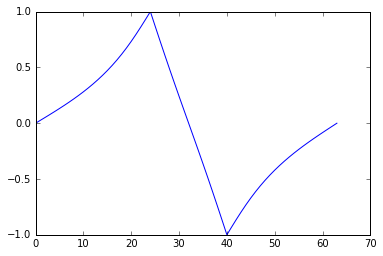

In [28]:
# check potential at a cutline in the middle of the square
plt.plot(potential[:,N/2])
plt.show()
# Potential is 0 at the ends. It reaches 1 at one capacitor plate and -1 at the other as expected.

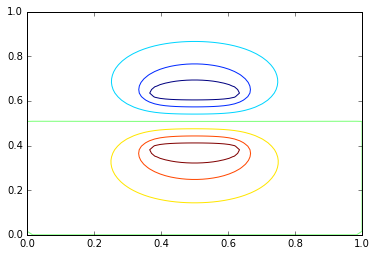

In [29]:
# Plot contours of potential 
x = np.linspace(0,1,N)
y = np.linspace(0,1,N)
X,Y = np.meshgrid(x,y)
plt.contour(X,Y,potential)

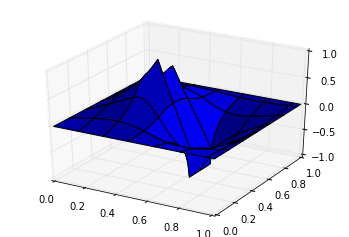

In [42]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Y,X,potential,shade=True)


The same idea can be extended to three dimensions. The discrete version of Laplace Equation becomes


\begin{align}
\ \phi_n[i,j,k] = \frac{1}{6} [\phi_{n-1}[i-1,j,k] + \phi_{n-1}[i+1,j,k]+\phi_{n-1}[i,j-1,k] + \phi_{n-1}[i,j+1,k] + \phi_{n-1}[i,j,k-1] + \phi_{n-1}[i,j,k+1] ]
\end{align}

The potential is updated by an average of its 6 neighbors (up, down, front back, left and right). This equation can also be written as a convolution of the previous potential with a kernel H since it is symmetrical. The kernel H now has three dimensions.

\begin{align}
\ \boldsymbol{\Phi_n} = \boldsymbol{\Phi_{n-1}} \circledast \boldsymbol{H}
\end{align}

H is a 3D array H[x,y,z] of dimensions 3x3x3. The kernel is given by:

\begin{align}
  H[:,:,0] =
  \begin{bmatrix}
  0 & 0 & 0 \\
  0 & \frac{1}{6} & 0 \\
  0 & 0 & 0 \\
  \end{bmatrix}
 \end{align}
 

\begin{align} 
  H[:,:,1] =
  \begin{bmatrix}
  0 & \frac{1}{6} & 0 \\
  \frac{1}{6} & 0 & \frac{1}{6} \\
  0 & \frac{1}{6} & 0 \\
  \end{bmatrix}
\end{align}


\begin{align} 
  H[:,:,2] =
  \begin{bmatrix}
  0 & 0 & 0 \\
  0 & \frac{1}{6} & 0 \\
  0 & 0 & 0 \\
  \end{bmatrix}
\end{align}

Extending the 2d example with 2 capacitor plates to 3D is straightforward. Scipy signal.convolve is now used which can handle n dimensional arrays.


In [5]:

import copy

N = 32          # number of grid points/ dimension
potential = np.zeros((N,N,N))
potential[:,0,:] = 0         # front     # allows changing BC for other problems
potential[:,N-1,:] = 0     # back
potential[0,:,:] = 0    # left
potential[N-1,:,:] = 0   # right
potential[:,:,0] = 0  # bottom
potential[:,:,N-1] = 0 # top
xM = N//2
yM = N//2
zM = N//2

dx = N//8
dy = N//8
dz = N//8
xL = xM-dx
xU = xM+dx
yL = yM-dy
yU = yM+dy

potential[xL:xU,yL:yU,zM+dz] = 1     # potential for 2 capacitor plates
potential[xL:xU,yL:yU,zM-dz] = -1


# make convolution kernel
H2D = np.zeros((3,3,3))
H2D[0,:,:] = [[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]]
H2D[1,:] = [[0.0,1.0,0.0],[1.0,0.0,1.0],[0.0,1.0,0.0]]
H2D[2,:] = H2D[0,:,:]
H2D = (1/6.0)*H2D
print(H2D[:,:,1])
print(H2D.shape)


potential =  signal.convolve(potential,H2D,mode='same') # sample update

[[0.         0.16666667 0.        ]
 [0.16666667 0.         0.16666667]
 [0.         0.16666667 0.        ]]
(3, 3, 3)


In [6]:
# function to solve for potential iteratively using convolution. Correlate function could be used as well 
def solveLaplace3D(potential,N,H2D):
    xM = N//2
    yM = N//2
    zM = N//2
    
    dx = N//8
    dy = N//8
    dz = N//8
    xL = xM-dx
    xU = xM+dx
    yL = yM-dy
    yU = yM+dy
    
    I = 100
        
        
    for i in range(I):
        potentialOld = copy.deepcopy(potential)
        #grid = signal.convolve(potential,H2D,mode='same')
        grid = signal.correlate(potential,H2D,mode='same')
        potential[1:N-1,1:N-1,1:N-1] = grid[1:N-1,1:N-1,1:N-1] # updates potential
        #enforce Boundary conditions
        potential[:,0,:] = 0         # front     # allows changing BC for other problems
        potential[:,N-1,:] = 0     # back
        potential[0,:,:] = 0    # left
        potential[N-1,:,:] = 0   # right
        potential[:,:,0] = 0  # bottom
        potential[:,:,N-1] = 0 # top
        
        potential[xL:xU,yL:yU,zM+dz] = 1     # potential for 2 capacitor plates
        potential[xL:xU,yL:yU,zM-dz] = -1
        maxError = np.abs(np.max(potential-potentialOld))
       
    return potential,maxError

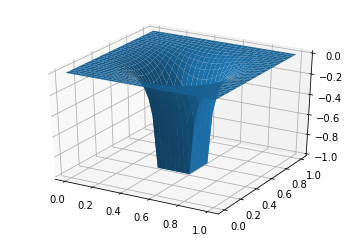

In [7]:
potential,maxE = solveLaplace3D(potential,N,H2D)
#print("final shape ",potential.shape)
#plt.plot(potential[xM,:,zM])

x = np.linspace(0,1,N)
y = np.linspace(0,1,N)
z = np.linspace(0,1,N)
X,Y = np.meshgrid(x,y)
#plt.contour(X,Y,potential[:,:,zM+dz])
#plt.show()

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,potential[:,:,zM-dz],shade=True)

The potential is harder to visualize now but we can look at cross sections. The figure above, for example, shows the potential on the plane of the bottom plate of the capacitor. The potential is zero at the boundaries, decreases smoothly, and becomes -1 at the area of the capacitor. This is expected from the boundary conditions. Similarly, the potential at the top plate is:

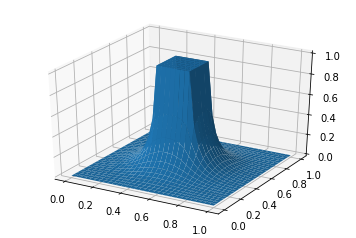

In [8]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,potential[:,:,zM+dz],shade=True)

# References
[1] Giordano and Nakanishi, Computational Physics, Second Edition 2006